# **レシピ14.6-7 ランダムフォレスト(RF)**
## **内容**
* 次元の呪いと相関係数
* panda-profilingによる可視化
* 単純なランダムフォレストによる分類
* ランダムフォレストによる重要な特徴量の特定(レシピ14.6)
* ランダムフォレストによる重要な特徴量の選択(レシピ14.7)
* まとめ・感想

　今回の内容は**特徴量の選定**ということにFocusする。

### **次元の呪い**
>>
　普通に考えるとデータの次元数は多ければ多い方がデータの特徴がよく分かるように思われるが、機械学習において次元数が大きすぎる場合に「次元の呪い」という現象が問題となる。次元の呪いとは「多すぎるポイントで見比べるとかえって違いが分からなくなる」ことであると言える。例えば、「引っ越しする物件を決める」場合には家賃や部屋の大きさなどを主に比較することになるが、他の要素までどんどん考慮に入れてしまうと、かえって一番よいものを比べにくくなる。実際には感覚的な話だけではなく、数学的にもデータ同士の違い(=距離)に差がつかなくなってしまうため、アルゴリズムの性能に大きな影響を及ぼす。

　参照：「図解即戦力　機械学習&ディープラーニングのしくみと技術がこれ1冊でしっかり分かる教科書」

### **強く相関した特徴量の取り扱い**
レシピ10.3に記載。
>>
　2つの特徴量が強く相関しているということは、それらの特徴量が持つ情報がよく似ているということで、両方持つのは冗長だということになる。この場合、どちらかを捨てると良い。

　pandas-profilingでは、ピアソンの相関係数とスピアマンの相関係数により相関関係が求められる。

* ピアソンの積率相関係数(https://bellcurve.jp/statistics/glossary/1233.html)
  * 2つの変数が正規分布に従う場合の相関係数を求めるのに使う  
  →求められた相関係数が有意であるかの検定を行うとき、2つの変数が正規分布に従っている仮定が必要のようです。

$$r_{xy} = \frac{{\displaystyle \sum_{i = 1}^n (x_i - \overline{x})
(y_i - \overline{y})}}{\sqrt{{\displaystyle \sum_{i = 1}^n 
(x_i - \overline{x})^2}} \sqrt{{\displaystyle \sum_{i = 1}^n 
(y_i - \overline{y})^2}}} = \frac{s_{xy}}{s_xs_y}
$$

* スピアマンの順位相関係数(https://bellcurve.jp/statistics/glossary/2052.html)
  * 各変量を順位に変換してピアソンの積率相関係数を求めたもの
  * 正規分布に従わない2つの変数間の相関係数を求めるのに使う
$$r_s = 1 - \frac{6\displaystyle \sum_{i = 1}^n {d_i}^2}{n(n^2 - 1)}$$

参照：[相関係数の有意性を確かめる方法について -相関係数について1歩踏み込む- - Data Science by R and Python](http://tomoshige-n.hatenablog.com/entry/2014/09/26/221108)  
参照：[スピアマン例題](http://www.tamagaki.com/math/Statistics609.html)

※一般の方のブログです。
## **pandas-profilingによる可視化**
　pandas-profilingによるデータの可視化を行います。こちらはGCI東大講座で薦められていたツールです。

　まずはpandas-profilingをimportしたいが、pandasのバージョンが1.0.5のままだと、pandas-profilingが正常に実行できないようなので、pandasのバージョンを落とします。ここでは、0.25.3に落としています。

In [4]:
# pandas-profilingを使いたいが、pandasのバージョン
# が上がっているためpandas-profiling側でエラーが出る

!pip uninstall pandas

Uninstalling pandas-0.25.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas-0.25.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-0.25.3


In [1]:
!pip install pandas==0.25.3

import pandas as pd
from pandas_profiling import ProfileReport
print(pd.__version__)

0.25.3


　以下でpandas-profilingによるデータの要約を行っている。基本統計量や頻度グラフ、ヒートマップなどの確認が可能。カラムにおいてHighly correlatedとなっているものは相関が高い他のカラムが存在するため、分析に使用しないことが推奨されている。

In [2]:
df = pd.read_csv('datasets_180_408_data.csv')

# df.replace({'diagnosis': {'M': 0, 'B': 1}}, inplace=True)

# pandas-profilingの結果をhtml形式で出力


profile = ProfileReport(df)
profile.to_file(outputfile="myoutputfile.html")

df

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


　以下で、削除が推奨されているカラムを出力している。

In [3]:
rejected_feature = profile.get_rejected_variables()
rejected_feature

['perimeter_mean',
 'area_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

## **単純なランダムフォレストの実行**
* 使用する説明変数は2列目から最後-1列目まで
* テストデータに3割使う
* ランダムフォレストのパラメータは初期値
* 評価指標は正解率

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 2列目から最後-1列目まで
X = df.iloc[:, 2:-1]
# 相関係数の高い片方を削除
# X = X.drop(columns=rejected_feature)
y = df["diagnosis"]

for i in range(20):
  # 検証データを30%にする
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

  # ランダムフォレスト
  rf = RandomForestClassifier()

  # 分類器を訓練
  model = rf.fit(X_train, y_train)

  # 予測
  y_pre = model.predict(X_test)

  print(accuracy_score(y_pre, y_test))

0.9415204678362573
0.9766081871345029
0.9239766081871345
0.9590643274853801
0.9824561403508771
0.9590643274853801
0.9590643274853801
0.9181286549707602
0.9824561403508771
0.9649122807017544
0.9766081871345029
0.9473684210526315
0.9532163742690059
0.9590643274853801
0.9590643274853801
0.9590643274853801
0.9415204678362573
0.9473684210526315
0.935672514619883
0.9824561403508771


In [11]:
X

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,0.11840,0.27760,0.30010,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.16220,0.66560,0.7119,0.4601,0.11890
1,20.57,17.77,0.08474,0.07864,0.08690,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.12380,0.18660,0.2416,0.2750,0.08902
2,19.69,21.25,0.10960,0.15990,0.19740,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.14440,0.42450,0.4504,0.3613,0.08758
3,11.42,20.38,0.14250,0.28390,0.24140,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.20980,0.86630,0.6869,0.6638,0.17300
4,20.29,14.34,0.10030,0.13280,0.19800,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.13740,0.20500,0.4000,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.11590,0.24390,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,0.14100,0.21130,0.4107,0.2060,0.07115
565,20.13,28.25,0.09780,0.10340,0.14400,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,0.11660,0.19220,0.3215,0.2572,0.06637
566,16.60,28.08,0.08455,0.10230,0.09251,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,0.11390,0.30940,0.3403,0.2218,0.07820
567,20.60,29.33,0.11780,0.27700,0.35140,0.2397,0.07016,0.7260,1.5950,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,0.16500,0.86810,0.9387,0.4087,0.12400


## **ランダムフォレストにおける重要な特徴量の特定**
### **問題**
ランダムフォレストモデルにおいて、最も重要な特徴量を知りたい。

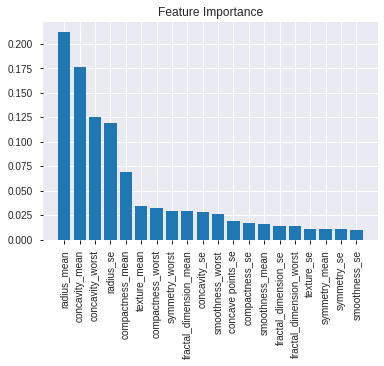

array([0.21180392, 0.17673158, 0.12505934, 0.11926625, 0.06899901,
       0.03392329, 0.03179029, 0.02918974, 0.02887719, 0.02814634,
       0.02591596, 0.01860471, 0.01655921, 0.01556387, 0.01349031,
       0.01347101, 0.01124204, 0.01119273, 0.0103991 , 0.00977409])

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

# 特徴量重要性を計算
importances = model.feature_importances_

# 特徴量重要性を降順にソート: argsortで昇順に並べ[::-1]で反転
indices = np.argsort(importances)[::-1]

# 特徴量の名前をソートした順に並び変え
names = [X.columns[i] for i in indices]

# プロットを作成
plt.figure()

# プロットのタイトルを作成
plt.title("Feature Importance")

# 棒グラフを追加
plt.bar(range(X.shape[1]), importances[indices])

# X軸に特徴量の名前を追加：rotation:ラベルを90度回転
plt.xticks(range(X.shape[1]), names, rotation=90)

# プロットを表示
plt.show()

# 特徴量重要度を表示
np.sort(model.feature_importances_)[::-1]

### **議論**
　まず、決定木においては不純度を大きく減少させる分割を与える特徴量が重要であった。

　特徴量の重要度については注意すべき点が2つある。
1. scikit-learnでは、名義的カテゴリ特徴量を複数の2値特徴量に分割する必要がある。これによって、元のカテゴリ特徴量の重要度が複数の分割後の特徴量に分散してしまう。このため元のカテゴリ特徴量が重要なものであっても、分割後の特徴量があまり重要でないように見えてしまうことがある。
2. 2つの特徴量に強い相関がある場合、そのうちの一方が重要度の多くを取ってしまい、もう一方が重要でなく見えてしまう場合がある。重要度を解釈する際にはこの可能性を考慮に入れる必要がある。  
→実際は重要なのに、相関関係のあるもう一方によって埋もれる


## **ランダムフォレストにおける重要な特徴量の選択**
### **問題**
　ランダムフォレストで、特徴量選択を行いたい。

### **解決策**
　特徴量重要度を算出し、重要度の高い特徴量だけを残してモデルを作る。

In [13]:
from sklearn.feature_selection import SelectFromModel
# 重要度が閾値以上の特徴量だけを選択するオブジェクトを生成
selector = SelectFromModel(model, threshold=0.06)

# 選択器を用いて新たな特徴量行列を作成
features_important = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(features_important, y, test_size = 0.3, random_state=0)

# 選択された重要度の高い特徴量を用いてランダムフォレストを訓練
model_select = rf.fit(X_train, y_train)


# 予測
y_pre = model_select.predict(X_test)

print(accuracy_score(y_pre, y_test))

0.9122807017543859


### **議論**
　モデルで用いる特徴量の数を削減したい場合があるが、これは例えば、モデルのバリアンスを低減したい場合や、重要な特徴量だけにしぼることでモデルを理解しやすくしたい場合などが該当する。このようなときに、上記の方法で重要度の高い特徴量だけを残す方法がある。

## **説明変数の個数を減らしながら、精度の変化を見る**
　以下では、**ランダムフォレストにおける特徴量の特定**で求めた重要度ごとに並べた特徴量(names)を用いて、説明変数を一つずつ増やしてその様子をグラフ化するプログラムである。

　namesは降順になっているので、6行目のコードで適宜昇順にする。

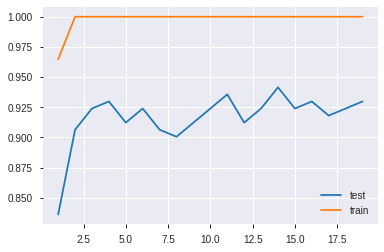

In [14]:
index = []
train_score = []
test_score = []

# 重要度が昇順に並べ替え
# names = names[::-1]

# 説明変数を一つずつ増やしてその様子をグラフ化
for i in range(1, len(X.columns)):
  X = df[names[:i]]
  y = df["diagnosis"]

  # 検証データを3割
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

  # ランダムフォレスト
  rf = RandomForestClassifier(random_state=0)

  # 分類器を訓練
  model = rf.fit(X_train, y_train)

  # 予測
  index.append(i)
  train_score.append(accuracy_score(model.predict(X_train), y_train))
  test_score.append(accuracy_score(model.predict(X_test), y_test))

plt.plot(index, test_score, label="test")
plt.plot(index, train_score, label="train")
plt.legend(loc = 'lower right')
plt.show()

## まとめ・感想
　特長量の重要度についてですが、教科書では重要度を求めた後に、閾値で特徴量をフィルターして、学習を行いました。また、相関関係については、相関のある2変数についてどちらか片方を削除することが求められました。しかし、これらによって特徴量の削除を行うと、どちらも精度的には下がってしまいました。やはり、特徴量の削減による情報の損失が大きかったのかと思いますが、半面、モデルのバリアンス(複雑さ)や理解のしやすさは改善されているのかと思います。課題としては、出来るだけ情報量の損失を減らしつつ、特徴量の削減を行うことではないでしょうか。  
　主成分分析などを使って、2変数を1つにまとめるなどを行うのも良い？のかもしれません。  
　また、相関関係の強い2つの変数に関して、「多重共線性」というものがあるというのを聞いたことがあります。これは重回帰モデルで発生するもので、以下のような症状を引き起こします。
>>
1. 分析結果における係数の標準誤差が大きくなる
2. t値が小さくなる
3. 決定係数が大きな値となる
4. 回帰係数の符号が本来なるべきものとは逆の符号となる

　相関関係のある2つの変数による不利益が発生するのは決定木においては明確に示されたものが見つからなかったので、手法に依るものがあるのではないかと思いました。

参照：[多重共線性とは？ 〜 概要と対応方法 〜 | 株式会社サイカ](https://xica.net/vno4ul5p/)